## Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

import plotly.express as px
import plotly.graph_objects as go

sns.set()

## Load Data

In [2]:
# The supplied CSV data file is the DataSet directory
fraud_df = pd.read_csv('../data/Fraud.csv')

## Data Information
- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## Plan of action
  ###  1. Change the type data to dummy variable
  ###  2. Check the balance of the target variable and balance if needed
  ###  3. Normalize (Scale) the numerical variable (may be not needed)
  ###  4. Check for multicollinearity
  ###  5. Modeling
  ###  6. Gris Search CV
  ###  7. Shap analysis

## Check Data

In [3]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
fraud_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
# Checking if there are null values
fraud_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There is no null values so no needed to clean any rows

In [7]:
# Name is particulary not importnat so lets drop column 4 and 7 (nameOrig and nameDest)

fraud_df.drop(columns=['nameOrig','nameDest'], inplace=True)
fraud_df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


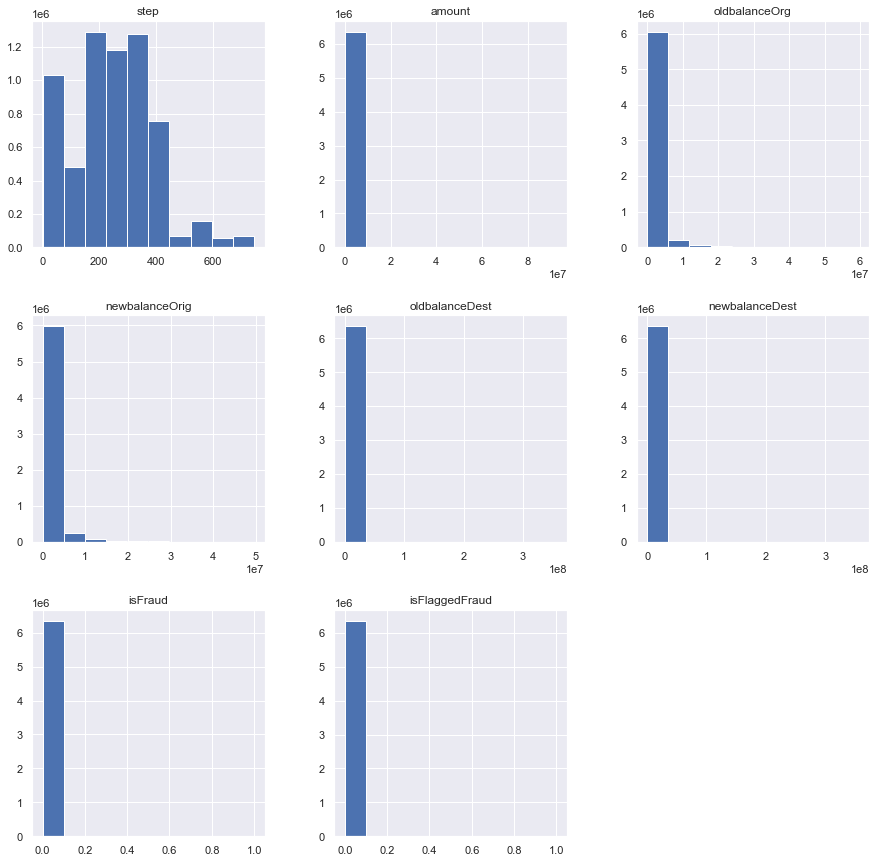

In [8]:
fraud_df.hist(figsize=(15, 15))
plt.show()

<AxesSubplot:>

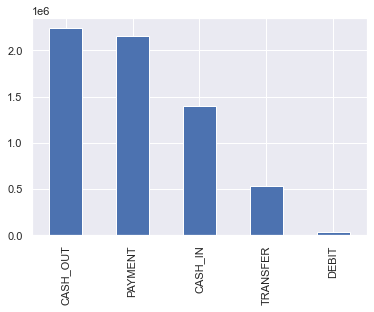

In [9]:
fraud_df['type'].value_counts().plot.bar()

In [10]:
fraud_df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [11]:
# Data is skewed so will need to normalize it

In [12]:
fraud_df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [13]:
# Same with isFlaggedfraud data but not that importnat

In [14]:
pd.get_dummies(fraud_df['type'])


,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
6362615,0,1,0,0,0
6362616,0,0,0,0,1
6362617,0,1,0,0,0
6362618,0,0,0,0,1


In [28]:
final_fraud_df = pd.concat([fraud_df.drop('type', axis=1), pd.get_dummies(fraud_df['type'])], axis=1)
final_fraud_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


<AxesSubplot:>

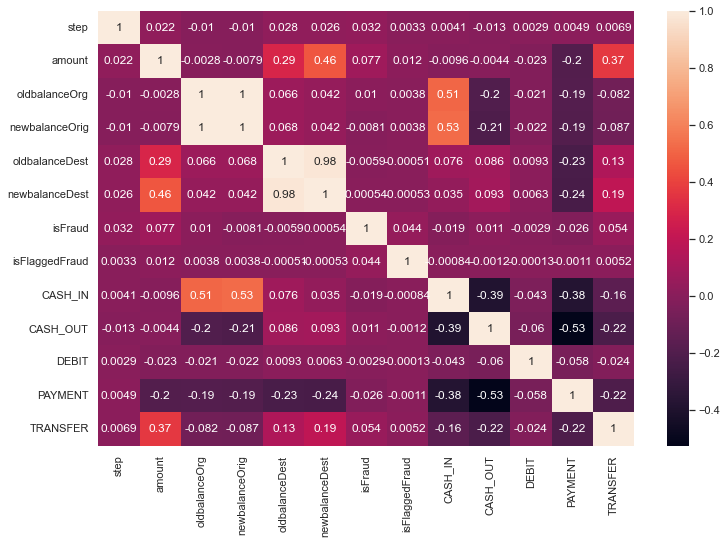

In [29]:
plt.figure(figsize=(12,8))
sns.heatmap(final_fraud_df.corr(), annot=True)

In [30]:
# save the cleaned data
final_fraud_df.to_csv('../clean_data/fraud_df.csv', index= False)